In [1]:
import sys
sys.path.append('../')

import optim_utils
import plot_utils
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
WYSCOUT_ID = 5414111
SKILLCORNER_ID = 952209

NETWORKS_PATH = f'../../data/networks/match_{SKILLCORNER_ID}/'
PASSES_DF_PATH = NETWORKS_PATH + 'passes_df.csv'

DATA_PATH= f'../../data/'
XT_PLOT_PATH = DATA_PATH + 'smoothed_xt.csv'
METADATA_PATH = DATA_PATH + f'skillcorner/{SKILLCORNER_ID}_metadata.csv'

In [3]:
passes_df = pd.read_csv(PASSES_DF_PATH)

In [4]:
xt_table = pd.read_csv(XT_PLOT_PATH)
pitch_length, pitch_width = pd.read_csv(METADATA_PATH)[['pitch_length', 'pitch_width']].values[0]
threat_map = optim_utils.ThreatMap(xt_table, pitch_length, pitch_width)

In [5]:
negative_frames = optim_utils.all_negative_dxt_frames(passes_df, threat_map)
passes_df = passes_df[~passes_df['frame'].isin(negative_frames)]

# Visualize Player Locations

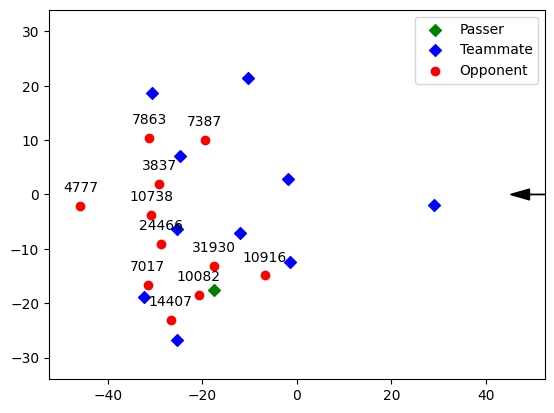

In [6]:
# frame_id = np.random.choice(passes_df['frame'].unique())
frame_id = 31966
pass_plotter = plot_utils.PassPlotter(passes_df, frame_id, pitch_length, pitch_width)
pass_plotter.plot_players()

In [7]:
frame_id = 31966
defender_id = 10082

# Defender Position Score Visualization

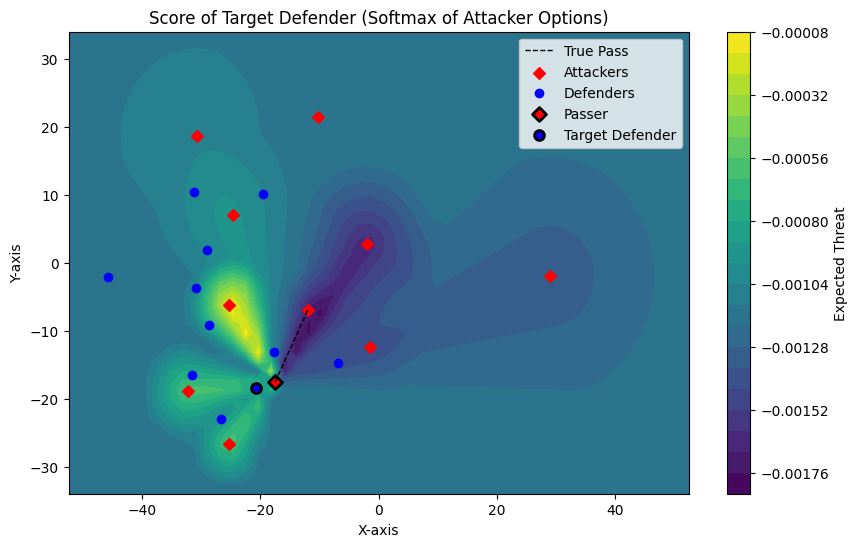

In [8]:
threat_func = optim_utils.create_xt_func_vectorized(defender_id, passes_df, frame_id, threat_map)
threat_agg = optim_utils.threat_aggregator('softmax', temp=0.03)
opt_func = lambda x, y: -threat_agg(threat_func(x, y))

pass_plotter = plot_utils.PassPlotter(passes_df, frame_id, pitch_length, pitch_width)
x_def, y_def = pass_plotter.get_player_location(defender_id)

ax = optim_utils.visualize_func(opt_func, x_def, y_def, radius=200, bound_x=pitch_length, bound_y=pitch_width, grid_res=50, contour_levels=20)
pass_plotter.plot_pass(ax, defender_id)
plt.legend()
plt.title('Score of Target Defender (Softmax of Attacker Options)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xlim([-pitch_length/2, pitch_length/2])
plt.ylim([-pitch_width/2, pitch_width/2])
plt.show()

# Best Passing Option

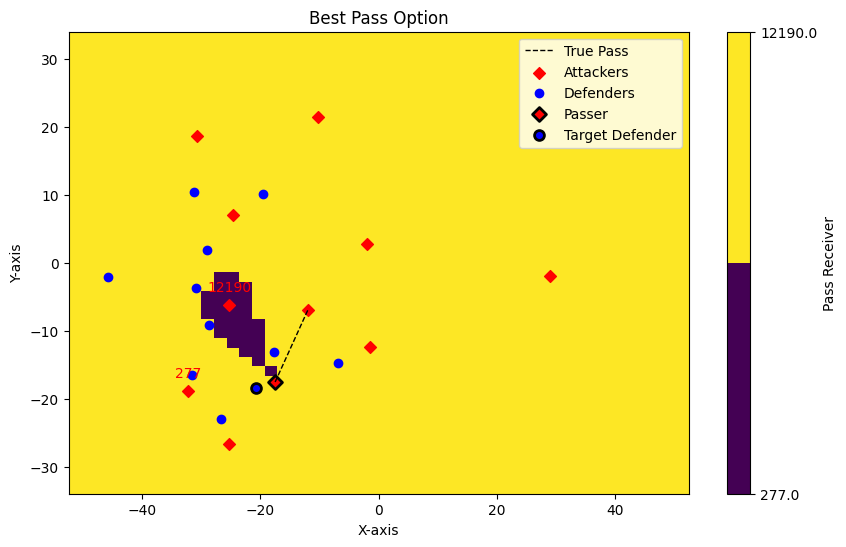

In [9]:
threat_func = optim_utils.create_xt_func_vectorized(defender_id, passes_df, frame_id, threat_map)
threat_agg = optim_utils.threat_aggregator('maxKey')
opt_func = lambda x, y: threat_agg(threat_func(x, y))

pass_plotter = plot_utils.PassPlotter(passes_df, frame_id, pitch_length, pitch_width)
x_def, y_def = pass_plotter.get_player_location(defender_id)

ax, candidate_recipients = optim_utils.visualize_best_pass(opt_func, x_def, y_def, radius=200, bound_x=pitch_length, bound_y=pitch_width, grid_res=50, return_recipients=True)

ax = plt.gca()
for label in candidate_recipients:
    x, y = pass_plotter.get_player_location(int(label))
    ax.annotate(int(label), (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10, color='red')

pass_plotter.plot_pass(ax, defender_id)
plt.legend()
plt.title('Best Pass Option')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xlim([-pitch_length/2, pitch_length/2])
plt.ylim([-pitch_width/2, pitch_width/2])
plt.show()

# Optimize Location

## Exhaustive Search

init_val: -0.0007774097691222137
opt_val: -0.00011294393802882278
improvement: 0.0006644658310933909
improvement_perc: 85.47176244564695
init_x: -20.82
init_y: -18.47
opt_x: -19.493469387755102
opt_y: -14.694489795918367
distance: 4.00176970431175


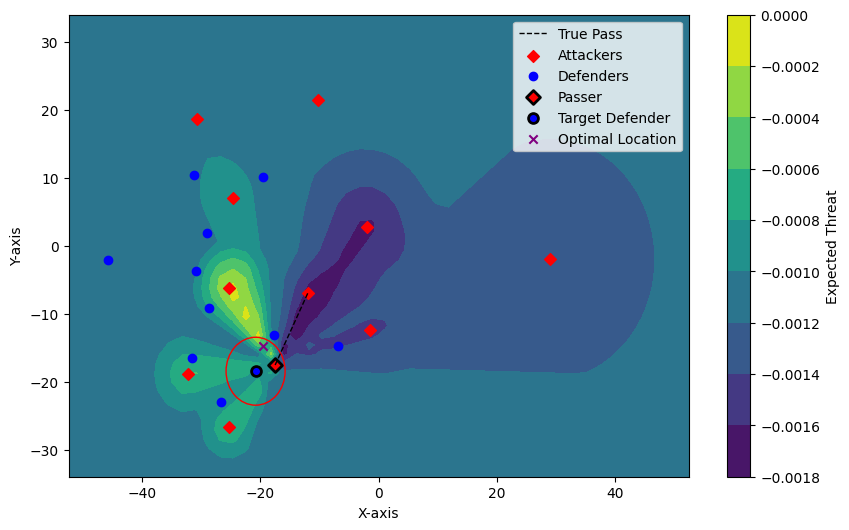

In [10]:
threat_func = optim_utils.create_xt_func_vectorized(defender_id, passes_df, frame_id, threat_map)
threat_agg = optim_utils.threat_aggregator('softmax', temp=0.03)
opt_func = lambda x, y: -threat_agg(threat_func(x, y))
pass_plotter = plot_utils.PassPlotter(passes_df, frame_id, pitch_length, pitch_width)


radius = 5
x_def, y_def = pass_plotter.get_player_location(defender_id)
Z_opt, x_opt, y_opt = optim_utils.optimize_func(opt_func, x_def, y_def, radius=radius, bound_x=pitch_length, bound_y=pitch_width, grid_res=50)
results = optim_utils.optimization_report(opt_func, x_def, y_def, x_opt, y_opt)
for k,v in results.items():
    print(f'{k}: {v}')


ax = optim_utils.visualize_func(opt_func, x_def, y_def, radius=200, bound_x=pitch_length, bound_y=pitch_width, grid_res=50, contour_levels=10)
pass_plotter.plot_pass(ax, defender_id, optimal_location=(x_opt, y_opt))
circle = plt.Circle((x_def, y_def), radius, color='r', fill=False)
ax.add_artist(circle)
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xlim([-pitch_length/2, pitch_length/2])
plt.ylim([-pitch_width/2, pitch_width/2])
plt.show()

## Bayesian Optimization

In [ ]:
from skopt import gp_minimize, dummy_minimize
from skopt.plots import plot_convergence

In [ ]:
threat_func = optim_utils.create_xt_func_vectorized(defender_id, passes_df, frame_id, threat_map)
threat_agg = optim_utils.threat_aggregator('softmax', temp=0.03)
opt_func = lambda x, y: -threat_agg(threat_func(x,y))
pass_plotter = plot_utils.PassPlotter(passes_df, frame_id, pitch_length, pitch_width)

radius = 5
x_def, y_def = pass_plotter.get_player_location(defender_id)

opt_func_list = lambda x: threat_agg(threat_func(x[0], x[1]))
res = gp_minimize(opt_func_list, 
                  [(x_def - radius, x_def + radius), (y_def - radius, y_def + radius)],
                  acq_func="gp_hedge",     
                  n_calls=30,         
                  n_random_starts=10,
                  random_state=1234,
                  x0=[x_def, y_def]) 

x_opt, y_opt = res.x
results = optim_utils.optimization_report(opt_func, x_def, y_def, x_opt, y_opt)
for k,v in results.items():
    print(f'{k}: {v}')

init_val: -0.0007774097691222137
opt_val: -0.00012078191160568251
improvement: 0.0006566278575165312
improvement_perc: 84.4635459441088
init_x: -20.82
init_y: -18.47
opt_x: -20.29314025089223
opt_y: -13.469999999999999
distance: 5.027681493017423


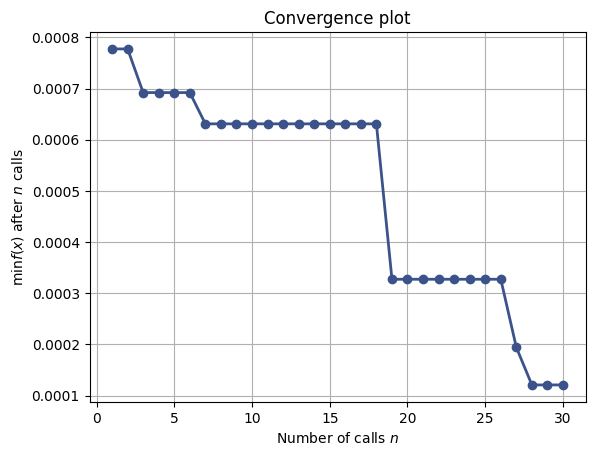

In [ ]:
plot_convergence(res)
plt.show()